In [73]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [66]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            yield from ()

In [25]:
# !ls /data/*/Run_182/rawdata/*.h5

/data/IRdelayscan/Run_182/rawdata/Run_182_483927046.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927146.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927246.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927346.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927446.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927546.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927646.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927746.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927846.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483927946.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928046.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928146.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928246.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928346.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928446.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928546.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928646.h5
/data/IRdelayscan/Run_182/rawdata/Run_182_483928746.h5
/data/IRde

In [67]:
run = 183
filenames = sorted(fn for fn in set(iglob(f"/data/IRdelayscan/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
bg_period, bg_mod = 3, 0  # /Background_Period

integ = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod
integ

,tag,tof,is_bg
npartitions=180,,,
,int64,object,bool
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [68]:
with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed | 35.1s


,count,summed
is_bg,,
True,6000,"[2653920.0, 2653849.0, 2653917.0, 2653950.0, 2..."
False,12000,"[5307697.0, 5307798.0, 5307706.0, 5307811.0, 5..."


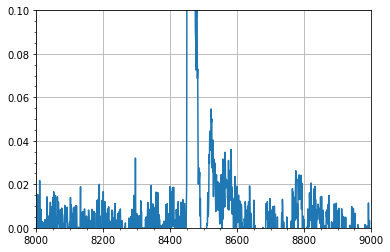

In [70]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 13000)
plt.ylim(0, 0.1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [72]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8000:9000].sum(),
                         'delay': round(dt, 2)}
                        for tag, iom, tof, dt
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01'
                                 '/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position']))
        except KeyError:
            yield from ()


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    )
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 48.9s


,delay,iom_intensity_pc,tag,tof_intensity
0,-6.30,122.823715,483969369,442378
1,-6.30,123.740387,483969370,442276
2,-6.30,140.659332,483969371,441910
3,-6.30,101.352310,483969372,442424
4,-6.30,141.356277,483969373,442170
5,-6.30,127.942657,483969374,442090
6,-6.30,138.908386,483969375,442372
7,-6.30,159.485435,483969376,442092
8,-6.30,159.337807,483969377,442012
9,-6.30,146.772194,483969378,442481


In [56]:
df['is_bg'] = df['tag'] % bg_period == bg_mod
groupped = df.groupby(['delay', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
groupped

count        sum
delay is_bg                  
-6.60 False   2000  884414176
      True    1000  442348327
-6.57 False   2000  884302413
      True    1000  442336036
-6.55 False   2000  884079620
      True    1000  442344699
-6.54 False     24   10610961
      True      13    5751363
-6.52 False   1976  873364112
      True     987  436603351
-6.50 False   2000  884030958
      True    1000  442326735
-6.47 False   1982  876258257
      True     991  438351941
-6.45 False   2000  884384243
      True    1000  442330368
-6.42 False   2000  884481052
      True    1000  442333431
-6.40 False   2000  884439618
      True    1000  442320944
-6.38 False      6    2652604
      True       3    1327148
-6.37 False   1992  880819671
      True     995  440110517
-6.35 False   2000  884114548
      True    1000  442303816
-6.32 False   1800  795510462
      True     900  398101982
 0.00 False      2     884156
      True       2     884418

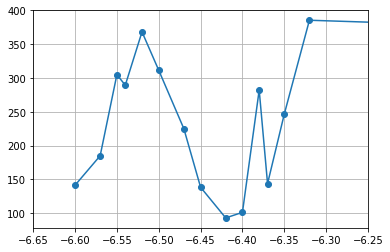

In [65]:
diff = -(
    (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count']).reset_index(level=1, drop=True)
    - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count']).reset_index(level=1, drop=True)
)
plt.figure()
plt.plot(diff, 'o-')
plt.xlim(-6.65, -6.25)
plt.grid(True)
plt.show()